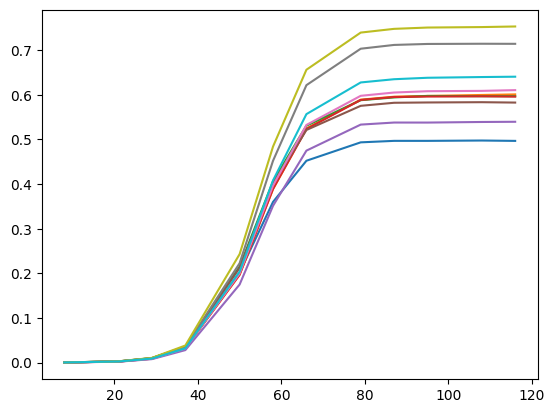

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import sbi.utils as utils
import torch
from sbi.inference import MCMCPosterior
from scipy.special import logsumexp
from cnv_simulation_initial_beneficial import CNVsimulator_simpleWF
from collective_posterior import CollectivePosterior
generation = np.array(pd.read_csv('Chuong_116_gens.txt').columns.astype('int'))
from seaborn import histplot

def simulator(parameters):
    X = CNVsimulator_simpleWF(parameters=parameters, generation=generation, N=int(2e6), seed=None, reps=10) \
    # + np.random.normal(0,0.01,(10,12))
    for i in range(len(X)):
        for j in range(len(X[i])):
            if X[i,j] > 1:
                X[i,j] = 1
            if X[i,j] < 0:
                X[i,j] = 0
    return X


X = simulator(np.array([-0.74,-4.84,-4.32], dtype='float'))
for x in X:
    plt.plot(generation,x)


In [2]:
prior_min = np.log10(np.array([1e-2,1e-7,1e-8]))
prior_max = np.log10(np.array([1,1e-2,1e-2]))
prior = utils.BoxUniform(low=torch.tensor(prior_min), 
                         high=torch.tensor(prior_max))
posterior_chuong = pickle.load(open(f'posterior_WF.pkl', 'rb'))
# posterior_lauer = pickle.load(open(f'posteriors/posterior_lauer.pkl', 'rb'))
n_eval = 300 # N used to calculate normalizng constant
epsilon = -150 # choice is detailed later
Xs = torch.tensor(X)
op = CollectivePosterior(prior, posterior_chuong, Xs, n_eval, 1, epsilon)
print(op.get_log_C())

tensor(515.2172)


In [3]:
op.sample(100).mean(0)

c:\Users\nadav\Desktop\research\Collective\collective_posterior\collective_posterior.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
c:\Users\nadav\Desktop\research\Collective\collective_posterior\collective_posterior.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)


tensor([-0.7324, -4.8568, -4.3596])

In [39]:
prior_min_t = np.log10(np.array([1e-1,1e-6,1e-6]))
prior_max_t = np.log10(np.array([0.2,1e-4,1e-4]))
test_prior = utils.BoxUniform(low=torch.tensor(prior_min_t), 
                         high=torch.tensor(prior_max_t))

prior_min = np.log10(np.array([1e-2,1e-7,1e-8]))
prior_max = np.log10(np.array([1,1e-2,1e-2]))
prior = utils.BoxUniform(low=torch.tensor(prior_min), 
                         high=torch.tensor(prior_max))
posterior_chuong = pickle.load(open(f'posterior_WF_20.pkl', 'rb'))
# posterior_lauer = pickle.load(open(f'posteriors/posterior_lauer.pkl', 'rb'))
n_eval = 300 # N used to calculate normalizng constant
epsilon = -150 # choice is detailed later


thetas = test_prior.sample((200,))
res = np.zeros_like(thetas)
for i in range(len(thetas)):
    theta = thetas[i]
    Xs = simulator(np.array(theta))
    op = CollectivePosterior(prior, posterior_chuong, Xs, n_eval, 1, epsilon=-150)
    print(op.get_log_C(samples=10000))
    m = op.sample(200).mean(0)
    res[i] = m - theta
    print(i)

tensor(-62.8823)


c:\Users\nadav\Desktop\research\Collective\collective_posterior\collective_posterior.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)


0
tensor(-51.8088)
1
tensor(-53.1068)
2
tensor(-68.0000)
3
tensor(-58.3899)
4
tensor(-70.3578)
5
tensor(-51.0650)
6
tensor(-35.4812)
7
tensor(-71.1045)
8
tensor(-27.0511)
9
tensor(-69.5465)
10
tensor(-69.0161)
11
tensor(-69.4030)
12
tensor(-17.9129)
13
tensor(-68.8283)
14
tensor(-54.8367)
15
tensor(-74.4878)
16
tensor(-49.5716)
17
tensor(-48.4980)
18
tensor(-59.7430)
19
tensor(-16.3400)
20
tensor(-49.9563)
21
tensor(-65.6092)
22
tensor(-46.9372)
23
tensor(-44.5604)
24
tensor(-60.4831)
25
tensor(-48.6734)
26
tensor(-51.4742)
27
tensor(-69.3773)
28
tensor(-46.8907)
29
tensor(-58.9504)
30
tensor(-2.0988)
31
tensor(-45.7788)
32
tensor(-19.5611)
33
tensor(-36.8961)
34
tensor(-55.8822)
35
tensor(-58.0672)
36
tensor(-14.4214)
37
tensor(-52.8379)
38
tensor(-63.2426)
39
tensor(-65.6917)
40
tensor(-11.2271)
41
tensor(-52.6901)
42
tensor(-58.1794)
43
tensor(-28.2170)
44
tensor(-68.5095)
45
tensor(-57.4155)
46
tensor(-42.9769)
47
tensor(-53.9607)
48
tensor(-50.9976)
49
tensor(-64.9328)
50
tensor(-

<Axes: ylabel='Density'>

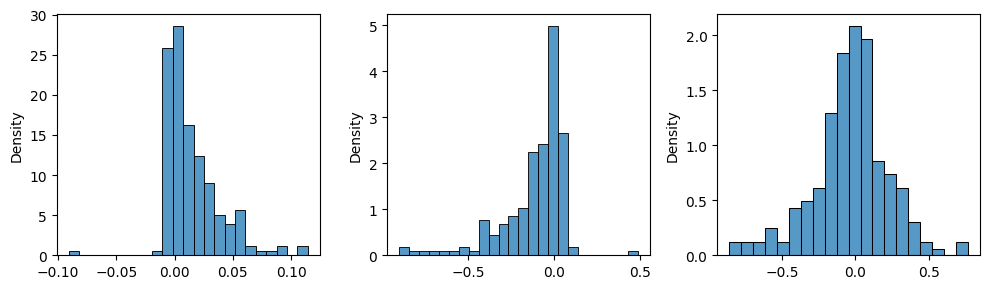

In [43]:
from seaborn import histplot
fig, ax = plt.subplots(1,3, figsize=(10,3), tight_layout = True)
histplot(res[:,0],ax=ax[0], stat='density')
histplot(res[:,1],ax=ax[1], stat='density')
histplot(res[:,2],ax=ax[2], stat='density')

In [47]:
torch.tensor(res).quantile(0.5, axis=0)

tensor([ 0.0084, -0.0544, -0.0248])

In [48]:
sbi_posterior = pickle.load(open(f'posterior_iid_WF_20.pkl', 'rb'))

res = np.zeros_like(thetas)
for i in range(len(thetas)):
    theta = thetas[i]
    Xs = simulator(np.array(theta))
    m = sbi_posterior.set_default_x(Xs).sample((200,)).mean(0)
    res[i] = m - theta
    print(i)

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

0


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

1


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

2


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

3


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

4


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

5


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

6


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

7


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

8


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

9


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

10


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

11


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

12


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

13


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

14


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

15


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

16


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

17


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

18


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

19


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

20


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

21


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

22


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

23


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

24


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

25


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

26


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

27


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

28


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

29


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

30


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

31


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

32


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

33


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

34


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

35


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

36


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

37


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

38


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

39


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

40


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

41


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

42


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

43


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

44


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

45


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

46


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

47


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

48


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

49


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

50


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

51


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

52


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

53


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

54


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

55


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

56


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

57


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

58


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

59


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

60


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

61


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

62


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

63


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

64


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

65


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

66


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

67


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

68


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

69


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

70


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

71


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

72


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

73


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

74


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

75


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

76


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

77


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

78


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

79


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

80


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

81


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

82


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

83


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

84


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

85


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

86


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

87


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

88


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

89


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

90


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

91


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

92


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

93


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

94


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

95


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

96


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

97


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

98


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

99


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

100


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

101


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

102


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

103


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

104


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

105


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

106


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

107


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

108


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

109


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

110


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

111


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

112


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

113


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

114


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

115


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

116


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

117


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

118


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

119


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

120


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

121


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

122


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

123


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

124


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

125


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

126


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

127


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

128


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

129


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

130


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

131


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

132


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

133


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

134


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

135


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

136


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

137


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

138


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

139


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

140


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

141


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

142


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

143


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

144


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

145


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

146


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

147


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

148


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

149


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

150


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

151


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

152


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

153


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

154


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

155


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

156


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

157


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

158


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

159


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

160


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

161


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

162


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

163


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

164


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

165


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

166


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

167


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

168


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

169


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

170


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

171


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

172


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

173


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

174


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

175


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

176


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

177


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

178


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

179


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

180


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

181


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

182


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

183


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

184


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

185


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

186


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

187


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

188


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

189


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

190


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

191


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

192


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

193


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

194


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

195


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

196


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

197


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

198


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

199


<Axes: ylabel='Density'>

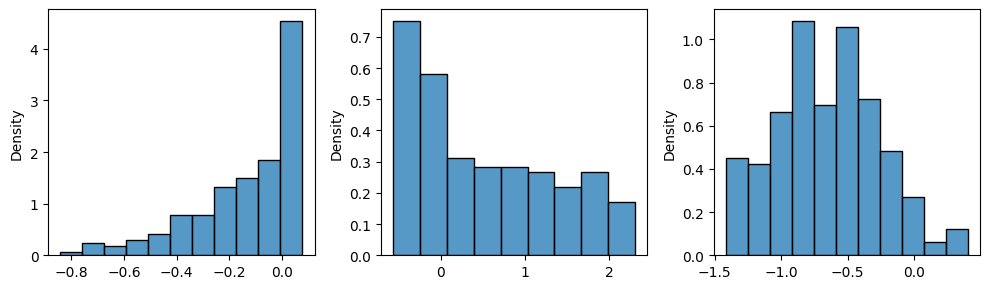

In [49]:
fig, ax = plt.subplots(1,3, figsize=(10,3), tight_layout = True)

histplot(res[:,0],ax=ax[0], stat='density')
histplot(res[:,1],ax=ax[1], stat='density')
histplot(res[:,2],ax=ax[2], stat='density')

In [50]:
torch.tensor(res).quantile(0.5, axis=0)

tensor([-0.0634,  0.3053, -0.6597])